In [1]:
import mne
import scipy
import pandas as pd
import numpy as np
import cebra
from cebra import CEBRA
import cebra.models
import matplotlib.pyplot as plt
import matplotlib as matlib

In [2]:
preprocess_dir = '../../data/SEED/SEED_EEG/Preprocessed_EEG'
extracted_dir = '../../data/SEED/SEED_EEG/ExtractedFeatures'
fq = 200
numBand = 5
channels = 62
out_dimensions = 8
persons = 15
sessions = 3
sectors = 15
epochSize = 200
epochStride = 100

bands = [1, 4, 8, 14, 31, 50]

# files = [['1_20131027', '1_20131030', '1_20131107'],
#          ['2_20140404', '2_20140413', '2_20
# eegs = scipy.io.loadmat(preprocess_dir + '/1_20131030.mat')
labels = scipy.io.loadmat(preprocess_dir + '/label.mat')['label'][0]

In [3]:
import os
files = os.listdir(preprocess_dir)
files.sort()
files = np.asarray(files)[: sessions * persons]

key_prefix = ['ww', 'ww', 'ww', 'wsf', 'wsf', 'wsf', 'wyw', 'wyw', 'wyw',
              'xyl', 'xyl', 'xyl', 'ys', 'ys', 'ys', 'zjy', 'zjy', 'zjy',
              'djc', 'djc', 'djc', 'jl', 'jl', 'jl', 'jj', 'jj', 'jj',
              'lqj', 'lqj', 'lqj', 'ly', 'ly', 'ly', 'mhw', 'mhw', 'mhw',
              'phl', 'phl', 'phl', 'sxy', 'sxy', 'sxy', 'wk', 'wk', 'wk']


In [4]:
# windows = [4000, 1000, 10]
# windows= [[200, 200],[400, 400],[800, 800],[1600,1600]]
# windows= [[800, 800]]
windows = [[400, 400]]

In [24]:
iter = 40000
batch_size = 256
feature_size = 6 * (numBand * 2 + 1)

time_de_train = np.empty([0, channels * feature_size])
time_de_test = np.empty([0, channels * feature_size])
emo_labels_train = np.empty([0, ], dtype=np.int32)
emo_labels_test = np.empty([0, ], dtype=np.int32)
subject_labels_train = np.empty([0, ], dtype=np.int32)
subject_labels_test = np.empty([0, ], dtype=np.int32)

In [6]:
test_ratio = 0.1
mod = (int)(1 / test_ratio)

def stat_feature(window):
    if (np.std(window) == 0):
        return [0] * 6
    de = np.log(np.std(window)) + 0.5 * np.log(2 * np.pi * np.e)
    return [np.max(window),np.min(window), np.mean(window), np.median(window), np.std(window), de]

def extract_feature(a :np.ndarray, window_size=100, stride=100):
    features = []
    i = 0
    while i + window_size <= a.shape[0]:
        # bandpass filter 1 - 75Hz
        # voltage features
        window = a[i : i + window_size]
        feature = stat_feature(window)

        # frequency features: mag
        magnitude, f_mag = matlib.mlab.magnitude_spectrum(window, Fs=fq)
        bins = np.digitize(f_mag, bands)
        mag = []
        current_bin = 1
        for j in range(magnitude.shape[0]):
            if bins[j] > 0 and bins[j] <= numBand:
                if (current_bin != bins[j]):
                    feature.extend(stat_feature(mag))
                    mag = []
                    current_bin = bins[j]
                mag.append(magnitude[j])
        if (len(mag) != 0):
            feature.extend(stat_feature(mag))

        if (len(feature) != 36):
            print(window)
        # frequency features: de
        psd, f_psd = matlib.mlab.psd(window, Fs=fq)
        bins = np.digitize(f_psd, bands)
        p = []
        current_bin = 1
        for j in range(psd.shape[0]):
            if bins[j] > 0 and bins[j] <= numBand:
                if (current_bin != bins[j]):
                    feature.extend(stat_feature(p))
                    p = []
                    current_bin = bins[j]
                p.append(psd[j])
        if (len(p) != 0):
            feature.extend(stat_feature(p))
            
        i += stride
        # if (len(feature) != 66):
        #     print(bins)
        features.append(np.array(feature))
    return np.array(features)

for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    if os.path.exists(data_path):
        continue
    time_de_train = np.empty([0, channels * feature_size])
    time_de_test = np.empty([0, channels * feature_size])
    emo_labels_train = np.empty([0, ], dtype=np.int32)
    emo_labels_test = np.empty([0, ], dtype=np.int32)
    subject_labels_train = np.empty([0, ], dtype=np.int32)
    subject_labels_test = np.empty([0, ], dtype=np.int32)
    for f in range(files.shape[0]):  
    # for f in range(1):
        eegs = scipy.io.loadmat(f'{preprocess_dir}/{files[f]}')
        epochs_time = np.empty([0, channels])
        epoch_time_labels = np.empty([0, ], dtype=np.int32)
        # per sector
        for i in range(1, sectors + 1):
            k = f'{key_prefix[f]}_eeg{str(i)}'
            epoch = np.apply_along_axis(extract_feature, 1, eegs[k], window, stride).swapaxes(0, 1)
            epoch = epoch.reshape(epoch.shape[0], -1)
            label = np.full((epoch.shape[0], ), labels[i - 1], dtype=np.int32)
            subject_label = np.full((epoch.shape[0], ), f // sessions, dtype=np.int32)
            index = f * sectors + i
            if index % mod == 0:
                time_de_test = np.append(time_de_test, epoch, axis=0)
                emo_labels_test = np.append(emo_labels_test, label)
                subject_labels_test = np.append(subject_labels_test, subject_label)
            else:
                time_de_train = np.append(time_de_train, epoch, axis=0)
                emo_labels_train = np.append(emo_labels_train, label)
                subject_labels_train = np.append(subject_labels_train, subject_label)

    emo_labels_train = emo_labels_train + 1
    emo_labels_test = emo_labels_test + 1
    print(time_de_train.shape, emo_labels_train.shape, subject_labels_train.shape)
    with open(data_path, 'wb') as f:
        np.save(f, time_de_train)
        np.save(f, time_de_test)
        np.save(f, emo_labels_train)
        np.save(f, emo_labels_test)
        np.save(f, subject_labels_train)
        np.save(f, subject_labels_test)

In [7]:
# models = [['offset10-model', 10]]
# models = [['offset36-model-dropout', 36]]
dimensions = [32]

In [8]:
print(time_de_train.shape)

(0, 4092)


In [9]:
iter = 10000
min_ratio = 1e-2
max_ratio = 1e2
channel_l = [0, 3, 8, 7, 6, 5, 17, 16, 15, 14, 26, 25, 24, 23, 35, 34, 
             33, 32, 44, 43, 42, 41, 52, 51, 50, 58, 57]
channel_r = [1, 4, 10, 11, 12, 13, 19, 20, 21, 22, 28, 29, 30, 31, 37, 38, 
             39, 40, 46, 47, 48, 49, 54, 55, 56, 60, 61]

def asym_channel(a: np.ndarray):
    a = a.reshape([channels, feature_size])
    ext_a = np.empty([0, feature_size])
    lower_bound = np.full([feature_size], min_ratio)
    for i in range(len(channel_l)):
        l = channel_l[i]
        r = channel_r[i]
        diff = a[r] - a[l]
        ext_a = np.append(ext_a, diff.reshape(1, diff.shape[0]), axis=0)
    for i in range(len(channel_l)):
        l = channel_l[i]
        r = channel_r[i]
        diff = np.clip(a[r]/np.where(a[l] == 0, lower_bound, a[l]), min_ratio, max_ratio)
        ext_a = np.append(ext_a, diff.reshape(1, diff.shape[0]), axis=0)
    return ext_a.flatten()

for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    ext_data_path = f'dataset/time_de_w{window}_stride{stride}_ext.npy'
    if os.path.exists(ext_data_path):
        continue
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
    ext_time_de_train = np.apply_along_axis(asym_channel, 1, time_de_train)
    ext_time_de_test = np.apply_along_axis(asym_channel, 1, time_de_test)
    with open(ext_data_path, 'wb') as f:
        np.save(f, ext_time_de_train)
        np.save(f, ext_time_de_test)


In [16]:
from cebra.models.model import _OffsetModel, ConvolutionalModelMixin
import cebra.models.layers as cebra_layers
from cebra.models import register
import torch
from torch import nn

model_name = "offset10-dropout-model8"
@register(model_name)
class Offset10DropoutModel(_OffsetModel, ConvolutionalModelMixin):
    def __init__(self, num_neurons, num_units, num_output, normalize=True):
        if num_units < 1:
            raise ValueError(
                f"Hiden dimension needs to be at least 1 , but got {num_units}."
            )
        super().__init__(
            # nn.Conv1d(num_neurons, num_units, 2),
            # nn.ReLU(),
            # # nn.Dropout1d(p=0.1),
            # # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.ReLU()),
            # # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.ReLU(), nn.MaxPool1d(3)),
            # # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU(), nn.MaxPool1d(3)),
            # nn.Conv1d(num_units, num_output, 3),
            nn.Conv1d(num_neurons, num_units, 2),
            nn.BatchNorm1d(num_units),
            nn.ReLU(),
            nn.Dropout(0.1),
            # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            # nn.Conv1d(num_units, num_output, 3),
            # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            nn.Conv1d(num_units, num_output, 2),
            num_input=num_neurons,
            num_output=num_output,
            normalize=normalize
        )

    def get_offset(self):
        return cebra.data.Offset(2, 3)

models = [[model_name, 10]]

In [ ]:
from cebra.models.model import _OffsetModel, ConvolutionalModelMixin
import cebra.models.layers as cebra_layers
from cebra.models import register
import torch
from torch import nn

model_name = "offset10-2Ddropout-model1"
@register(model_name)
class Offset10DropoutModel(_OffsetModel, ConvolutionalModelMixin):
    def __init__(self, num_neurons, num_units, num_output, normalize=True):
        if num_units < 1:
            raise ValueError(
                f"Hiden dimension needs to be at least 1 , but got {num_units}."
            )
        super().__init__(
            # nn.Conv1d(num_neurons, num_units, 2),
            # nn.ReLU(),
            # # nn.Dropout1d(p=0.1),
            # # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.ReLU()),
            # # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.ReLU(), nn.MaxPool1d(3)),
            # # cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU(), nn.MaxPool1d(3)),
            # nn.Conv1d(num_units, num_output, 3),
            nn.Conv2d(num_neurons, num_units, 2),
            # nn.BatchNorm1d(num_units),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            nn.GELU(),
            cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            cebra_layers._Skip(nn.Conv1d(num_units, num_units, 3), nn.BatchNorm1d(num_units), nn.ReLU(), nn.Dropout(0.1)),
            nn.Conv1d(num_units, num_output, 3),
            num_input=num_neurons,
            num_output=num_output,
            normalize=normalize
        )

    def get_offset(self):
        return cebra.data.Offset(5, 5)

models = [[model_name, 10]]

In [10]:
models = [['offset10-model', 10]]
dimensions = [32]

In [ ]:
from sklearn.utils import shuffle

iter = 10000
def getMagDe(a: np.ndarray, chs=channels, startCh=0, endCh=channels, start=6, end=6*numBand+6):
    a = a.reshape(-1, chs, feature_size)
    a = a[:, startCh: endCh, start: end].reshape(a.shape[0], -1)
    return a
    
for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    ext_data_path = f'dataset/time_de_w{window}_stride{stride}_ext.npy'
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
        time_de_train = getMagDe(time_de_train, chs=channels)
        time_de_test = getMagDe(time_de_test, chs=channels)
        emo_labels_train = np.load(f)
        emo_labels_test = np.load(f)
        subject_labels_train = np.load(f)
        subject_labels_test = np.load(f)
    with open(ext_data_path, 'rb') as f:
        ext_time_de_train = np.load(f)
        ext_time_de_test = np.load(f)
        ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
        ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
    time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
    time_de_train, emo_labels_train = shuffle(time_de_train, emo_labels_train, random_state=42)
    time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
    for model_name, offset in models:
        for d in dimensions:
            # for use_label in ['emo', 'subject', 'none']:
            for use_label in ['emo']:
                model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magonly.model'
                if os.path.exists(model_path):
                    continue
                print(model_path)
                cebra_model = CEBRA(
                    model_architecture = model_name,
                    batch_size = batch_size,
                    temperature_mode="auto",
                    learning_rate = 0.001,
                    max_iterations = iter * d,
                    time_offsets = offset,
                    output_dimension = d,
                    device = "cuda_if_available",
                    verbose = True
                )
                if use_label == 'emo':
                    cebra_model.fit(time_de_train, emo_labels_train)
                elif use_label == 'subject':
                    cebra_model.fit(time_de_train, subject_labels_train)
                else:
                    cebra_model.fit(time_de_train)
                cebra_model.save(model_path)
                cebra.plot_loss(cebra_model)

model/ext_time_de_feature_offset10-dropout-model8_d32_i320000_labelemo_w400_s400_magonly.model


pos:  0.0418 neg:  4.8400 total:  4.8818 temperature:  0.1000:  96%|█████████▌| 306868/320000 [1:00:04<02:34, 85.06it/s]

In [14]:
np.unique(emo_labels_test)

array([0, 1, 2], dtype=int32)

In [ ]:
iter = 600

def getPsdDe(a: np.ndarray):
    a = a.reshape(-1, channels, feature_size)
    a = a[:, :, 6 * numBand + 6:].reshape(a.shape[0], -1)
    return a
    
for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    ext_data_path = f'dataset/time_de_w{window}_stride{stride}_ext.npy'
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
        time_de_train = getPsdDe(time_de_train)
        time_de_test = getPsdDe(time_de_test)
        emo_labels_train = np.load(f)
        emo_labels_test = np.load(f)
        subject_labels_train = np.load(f)
        subject_labels_test = np.load(f)
    with open(ext_data_path, 'rb') as f:
        ext_time_de_train = np.load(f)
        ext_time_de_test = np.load(f)
    for model_name, offset in models:
        for d in dimensions:
            # for use_label in ['emo', 'subject', 'none']:
            for use_label in ['emo']:
                model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_psdonly.model'
                if os.path.exists(model_path):
                    continue
                print(model_path)
                cebra_model = CEBRA(
                    model_architecture = model_name,
                    batch_size = batch_size,
                    temperature_mode="auto",
                    learning_rate = 0.001,
                    max_iterations = iter * d,
                    time_offsets = offset,
                    output_dimension = d,
                    device = "cuda_if_available",
                    verbose = False
                )
                if use_label == 'emo':
                    cebra_model.fit(time_de_train, emo_labels_train)
                elif use_label == 'subject':
                    cebra_model.fit(time_de_train, subject_labels_train)
                else:
                    cebra_model.fit(time_de_train)
                cebra_model.save(model_path)
                cebra.plot_loss(cebra_model)

model/ext_time_de_feature_offset10-model_d32_i19200_labelemo_w400_s400_psdonly.model


In [23]:
iter=600

model/ext_time_de_feature_offset10-model_d32_i32_labelemo_w400_s400_magtime.model


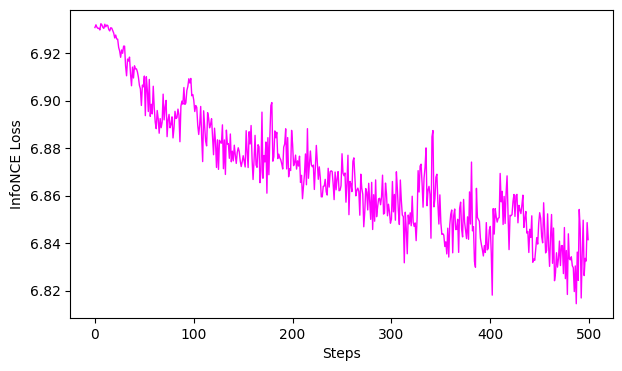

In [26]:
# adapt fit more iterations
from sklearn import svm
from joblib import dump, load

for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
        time_de_train = getMagDe(time_de_train)
        time_de_test = getMagDe(time_de_test)
        emo_labels_train = np.load(f)
        emo_labels_test = np.load(f)
        subject_labels_train = np.load(f)
        subject_labels_test = np.load(f)
    with open(ext_data_path, 'rb') as f:
        ext_time_de_train = np.load(f)
        ext_time_de_test = np.load(f)
        ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
        ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
    time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
    time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
    for model_name, offset in models:
        for d in dimensions:
            more_iters = 1 * d
            # for use_label in ['emo', 'subject', 'none']:
            for use_label in ['emo']:
                model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magtime.model'
                print(model_path)
                if not os.path.exists(model_path):
                    print("not existed")
                cebra_model = cebra.CEBRA.load(model_path)
                # cebra_model.max_iterations = more_iters
                cebra_model.fit(time_de_train, emo_labels_train, adapt=True)
                del cebra_model.state_
                cebra_model.save(model_path)
                cebra.plot_loss(cebra_model)

In [22]:
models = [['offset10-dropout-model8', 10]]
dimensions = [32]
iter = 500

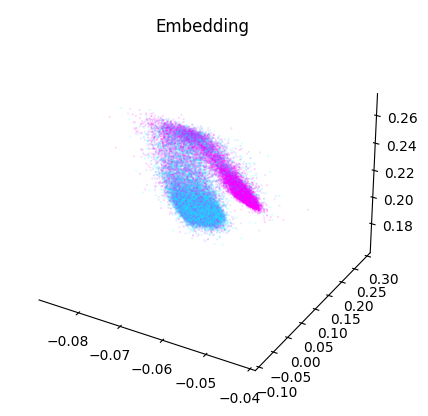

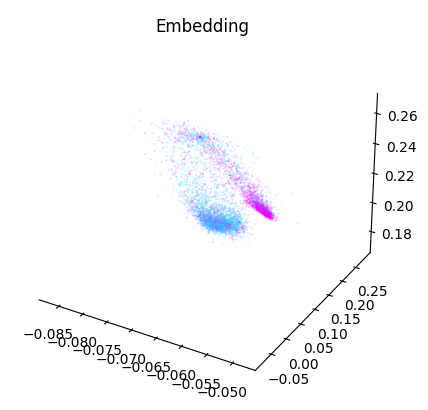

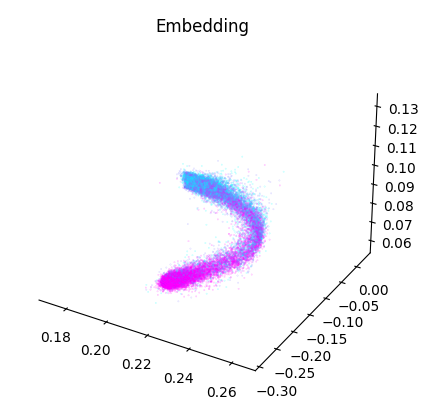

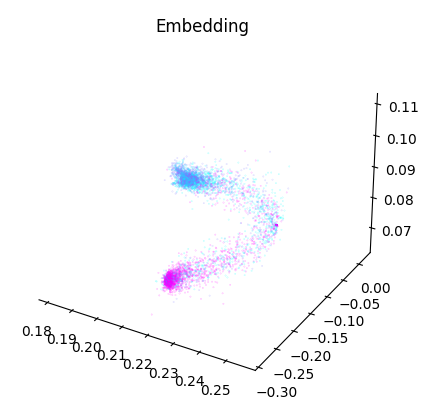

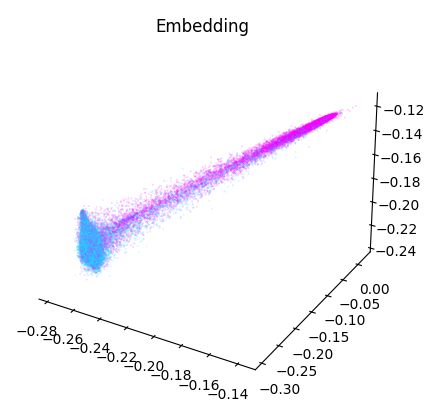

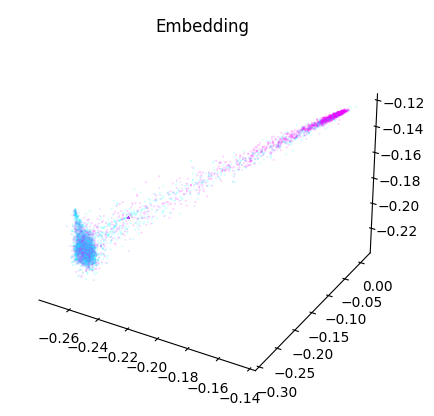

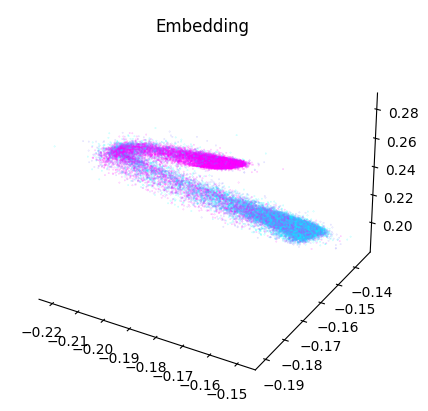

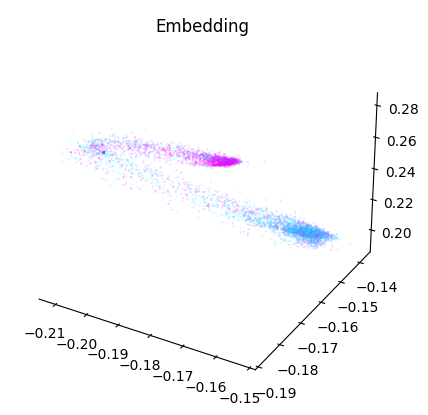

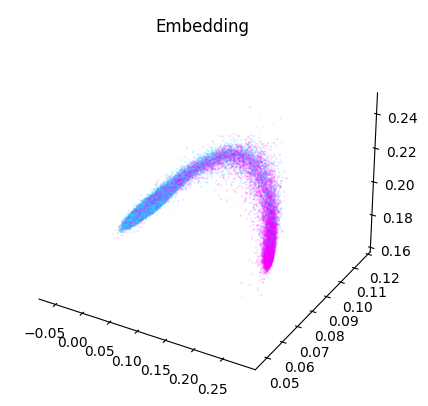

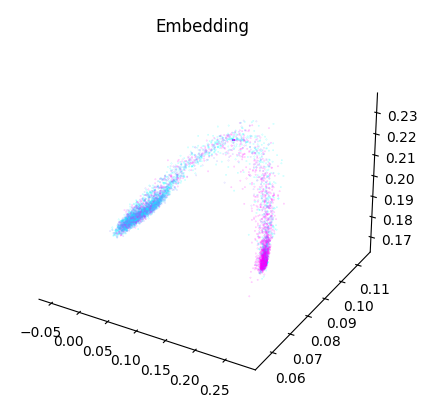

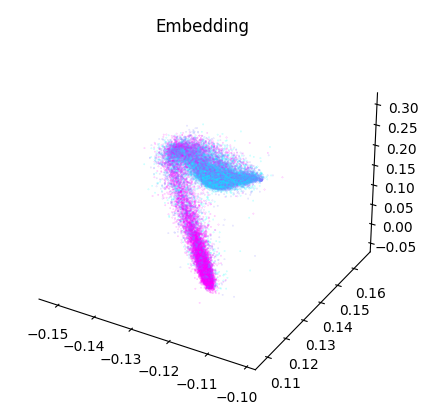

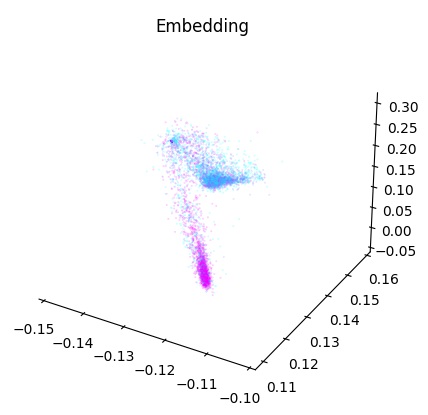

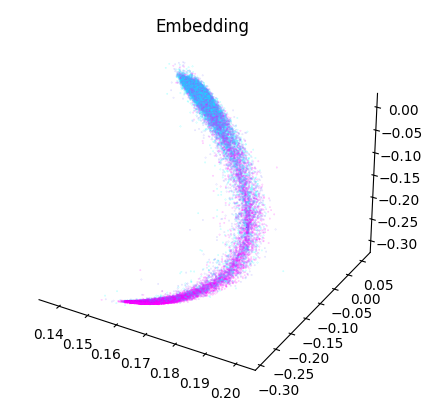

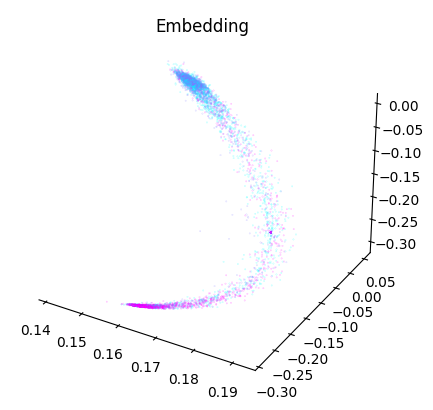

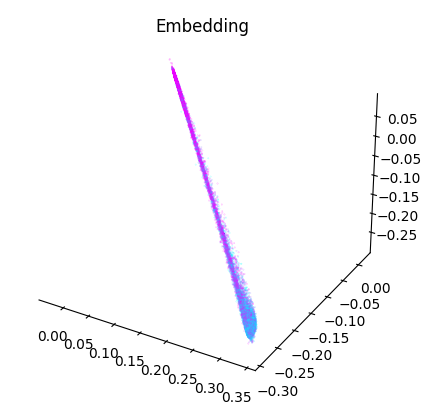

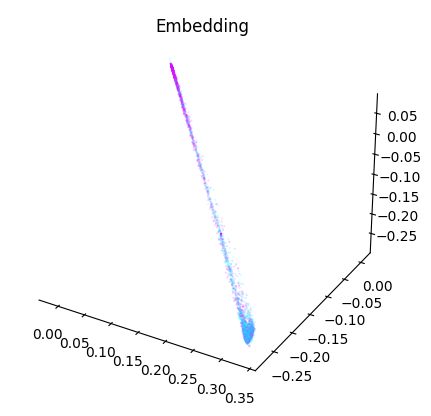

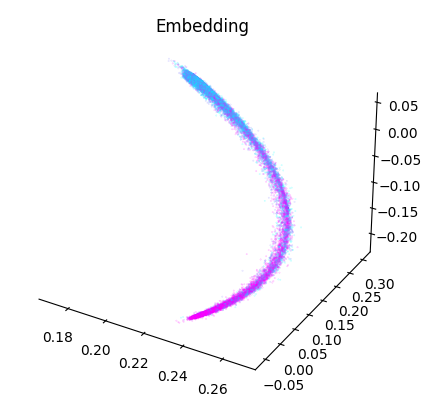

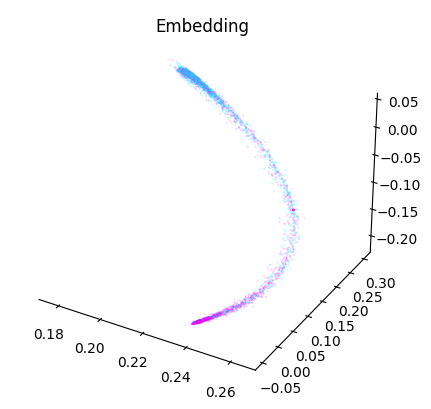

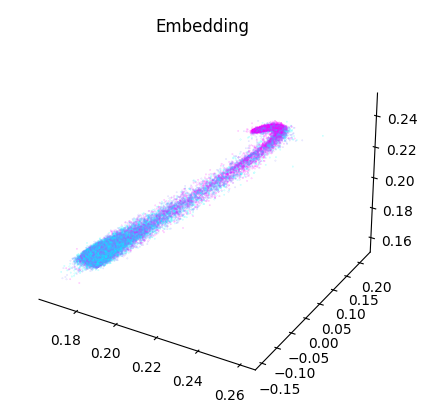

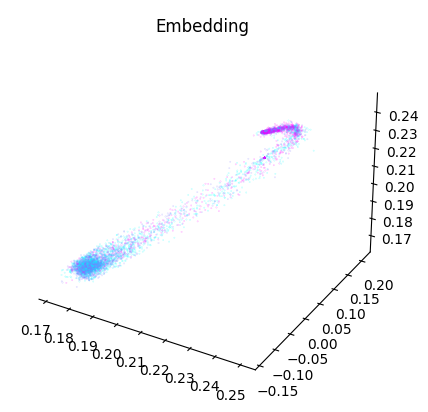

In [29]:
from sklearn import svm
from joblib import dump, load

for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
        time_de_train = getMagDe(time_de_train)
        time_de_test = getMagDe(time_de_test)
        emo_labels_train = np.load(f)
        emo_labels_test = np.load(f)
        subject_labels_train = np.load(f)
        subject_labels_test = np.load(f)
    with open(ext_data_path, 'rb') as f:
        ext_time_de_train = np.load(f)
        ext_time_de_test = np.load(f)
        ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
        ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
    time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
    time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
    for model_name, offset in models:
        for d in dimensions:
            # for use_label in ['emo', 'subject', 'none']:
            for use_label in ['emo']:
                model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magonly.model'
                cebra_model = cebra.CEBRA.load(model_path)
                embeddings_train = cebra_model.transform(time_de_train)
                embeddings_test = cebra_model.transform(time_de_test)
                for axe in range(10):
                    axis = (axe * 3, axe * 3 + 1, axe * 3 + 2)
                    cebra.plot_embedding(embeddings_train, embedding_labels=emo_labels_train, idx_order=axis)
                    cebra.plot_embedding(embeddings_test, embedding_labels=emo_labels_test, idx_order=axis)

In [ ]:
from sklearn import svm
from joblib import dump, load

# iter = 10000
for k in [5]:
    decoder = svm.NuSVC(gamma="auto")

    for window, stride in windows:
        data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
        with open(data_path, 'rb') as f:
            time_de_train = np.load(f)
            time_de_test = np.load(f)
            time_de_train = getMagDe(time_de_train)
            time_de_test = getMagDe(time_de_test)
            emo_labels_train = np.load(f)
            emo_labels_test = np.load(f)
            subject_labels_train = np.load(f)
            subject_labels_test = np.load(f)
        with open(ext_data_path, 'rb') as f:
            ext_time_de_train = np.load(f)
            ext_time_de_test = np.load(f)
            ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l))
            ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l))
        time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
        time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
        for model_name, offset in models:
            for d in dimensions:
                # for use_label in ['emo', 'subject', 'none']:
                for use_label in ['emo']:
                    model_path = f'model/time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}.model'
                    cebra_model = cebra.CEBRA.load(model_path)
                    embeddings_train = cebra_model.transform(time_de_train)
                    embeddings_test = cebra_model.transform(time_de_test)
                    if use_label == 'none' or use_label == 'emo':
                        decoder.fit(embeddings_train, emo_labels_train.flatten())
                        predict_labels_train = decoder.predict(embeddings_train)
                        predict_labels_test = decoder.predict(embeddings_test)
                        # print(predict_labels_train, emo_labels_train)
                        # print(predict_labels_test, emo_labels_test)
                        acc_train = np.sum(predict_labels_train == emo_labels_train.flatten()) / predict_labels_train.shape[0]
                        acc_test = np.sum(predict_labels_test == emo_labels_test.flatten()) / predict_labels_test.shape[0]
                        print(acc_train, acc_test)
                    if (use_label == 'none' or use_label == 'subject'):
                        decoder.fit(embeddings_train, subject_labels_train.flatten())
                        predict_labels_train = decoder.predict(embeddings_train)
                        predict_labels_test = decoder.predict(embeddings_test)
                        # print(predict_labels_train, predict_labels_test)
                        acc_train = np.sum(predict_labels_train == subject_labels_train.flatten()) / predict_labels_train.shape[0]
                        acc_test = np.sum(predict_labels_test == subject_labels_test.flatten()) / predict_labels_test.shape[0]
                        print(acc_train, acc_test)

In [45]:
from sklearn import svm
from joblib import dump, load

# iter = 10000
for k in [5]:
    decoder = cebra.KNNDecoder(k)

    for window, stride in windows:
        data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
        with open(data_path, 'rb') as f:
            time_de_train = np.load(f)
            time_de_test = np.load(f)
            time_de_train = getMagDe(time_de_train)
            time_de_test = getMagDe(time_de_test)
            emo_labels_train = np.load(f)
            emo_labels_test = np.load(f)
            subject_labels_train = np.load(f)
            subject_labels_test = np.load(f)
        with open(ext_data_path, 'rb') as f:
            ext_time_de_train = np.load(f)
            ext_time_de_test = np.load(f)
            ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
            ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
        time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
        time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
        for model_name, offset in models:
            for d in dimensions:
                # for use_label in ['emo', 'subject', 'none']:
                for use_label in ['emo']:
                    # model_path = f'model/time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}.model'
                    model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magonly.model'
                    cebra_model = cebra.CEBRA.load(model_path)
                    embeddings_train = cebra_model.transform(time_de_train)
                    embeddings_test = cebra_model.transform(time_de_test)
                    if use_label == 'none' or use_label == 'emo':
                        decoder.fit(embeddings_train, emo_labels_train.flatten())
                        predict_labels_train = decoder.predict(embeddings_train)
                        predict_labels_test = decoder.predict(embeddings_test)
                        # print(predict_labels_train, emo_labels_train)
                        # print(predict_labels_test, emo_labels_test)
                        acc_train = np.sum(predict_labels_train == emo_labels_train.flatten()) / predict_labels_train.shape[0]
                        acc_test = np.sum(predict_labels_test == emo_labels_test.flatten()) / predict_labels_test.shape[0]
                        print(acc_train, acc_test)
                    if (use_label == 'none' or use_label == 'subject'):
                        decoder.fit(embeddings_train, subject_labels_train.flatten())
                        predict_labels_train = decoder.predict(embeddings_train)
                        predict_labels_test = decoder.predict(embeddings_test)
                        # print(predict_labels_train, predict_labels_test)
                        acc_train = np.sum(predict_labels_train == subject_labels_train.flatten()) / predict_labels_train.shape[0]
                        acc_test = np.sum(predict_labels_test == subject_labels_test.flatten()) / predict_labels_test.shape[0]
                        print(acc_train, acc_test)

0.9994937514464244 0.6591947458595089


In [43]:
print(predict_labels_test)

[1 2 2 ... 2 2 2]


In [41]:
from joblib import dump, load
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# iter = 10000
mini_batch = 200
train_epoch = 1000
dropout_prob = 0.1

class NNClassifier(nn.Module):
    def __init__(self, int_dim, out_dim):
        super().__init__()
        self.linear_relu = nn.Sequential(
            # nn.Linear(int_dim, int_dim // 2),
            nn.Linear(int_dim, int_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(int_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            # nn.BatchNorm1d(int_dim // 2),
            # nn.Linear(int_dim // 2, out_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x.to(torch.float32)
        return self.linear_relu(x)

class EmbeddingDataset(Dataset):
    def __init__(self, input, labels):
        self.input = torch.from_numpy(input).cuda()
        self.labels = torch.from_numpy(labels).type(torch.LongTensor).cuda()

    def __len__(self):
        return self.input.size(dim=0)

    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]
        

def trainNNClassifer(classifier : nn.Module, data: Dataset, batch_size, epochs, tol=1e-7):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classifier.to(device)
    loss = nn.CrossEntropyLoss()
    opt = optim.Adam(classifier.parameters(), weight_decay=0.0005)
    running_loss = 0.0
    num_tol = 0

    dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        start_loss = running_loss
        for i, batch in enumerate(dataLoader):
            classifier.zero_grad()
            inputs, labels = batch
            logits = classifier(inputs)
            l = loss(logits, labels)
            l.backward()
            opt.step()
            
            # print statistics
            running_loss += l.item()
            # if i % 100 == 99:    # print every 2000 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #     running_loss = 0.0
        if epoch % 100 == 0:
            print(epoch, running_loss)
        delta_loss = running_loss - start_loss
        running_loss = 0
        if delta_loss <= tol:
            num_tol += 1
        else:
            num_tol = 0
        if (num_tol >= 10):
            print(f'num_tol >= 10')
            break;
            

    print('Finished Training')
        

for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
        time_de_train = getMagDe(time_de_train)
        time_de_test = getMagDe(time_de_test)
        emo_labels_train = np.load(f)
        emo_labels_test = np.load(f)
        subject_labels_train = np.load(f)
        subject_labels_test = np.load(f)
    with open(ext_data_path, 'rb') as f:
        ext_time_de_train = np.load(f)
        ext_time_de_test = np.load(f)
        ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
        ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
    time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
    time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
    for model_name, offset in models:
        for d in dimensions:
            # for use_label in ['emo', 'subject', 'none']:
            for use_label in ['emo']:
                model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magonly.model'
                cebra_model = cebra.CEBRA.load(model_path)
                embeddings_train = cebra_model.transform(time_de_train)
                embeddings_test = cebra_model.transform(time_de_test)
                if use_label == 'none' or use_label == 'emo':
                    model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magonly.model'
                    numClass = 3;
                    decoder = NNClassifier(d, numClass) 
                    dataset_train = EmbeddingDataset(embeddings_train, emo_labels_train.flatten())
                    trainNNClassifer(classifier=decoder, data=dataset_train, batch_size=mini_batch, epochs=train_epoch)
                    torch.save(decoder.state_dict(), decoder_path)
                    dataset_test = EmbeddingDataset(embeddings_test, emo_labels_test.flatten())
                    predict_labels_train = decoder(torch.from_numpy(embeddings_train).cuda())
                    predict_labels_test = decoder(torch.from_numpy(embeddings_test).cuda())
                    # print(predict_labels_train, emo_labels_train)
                    # print(predict_labels_test, emo_labels_test)
                    predict_labels_train = np.argmax(predict_labels_train.detach().cpu().numpy(), axis=1)
                    predict_labels_test = np.argmax(predict_labels_test.detach().cpu().numpy(), axis=1)
                    acc_train = np.sum(predict_labels_train == emo_labels_train.flatten()) / predict_labels_train.shape[0]
                    acc_test = np.sum(predict_labels_test == emo_labels_test.flatten()) / predict_labels_test.shape[0]
                    print(acc_train, acc_test)
                if (use_label == 'none' or use_label == 'subject'):
                    numClass = persons
                    decoder.fit(embeddings_train, subject_labels_train.flatten())
                    predict_labels_train = decoder.predict(embeddings_train)
                    predict_labels_test = decoder.predict(embeddings_test)
                    # print(predict_labels_train, predict_labels_test)
                    acc_train = np.sum(predict_labels_train == subject_labels_train.flatten()) / predict_labels_train.shape[0]
                    acc_test = np.sum(predict_labels_test == subject_labels_test.flatten()) / predict_labels_test.shape[0]
                    print(acc_train, acc_test)

RuntimeError: mat1 and mat2 must have the same dtype

In [27]:
from joblib import dump, load
from sklearn.neural_network import MLPClassifier

# iter = 10000
mini_batch = 200
train_epoch = 1000

decoder = MLPClassifier(hidden_layer_sizes=[16,16], activation='relu', max_iter=train_epoch, batch_size=mini_batch)
decoder.out_activation_ = 'softmax'

for window, stride in windows:
    data_path = f'dataset/time_de_w{window}_stride{stride}.npy'
    with open(data_path, 'rb') as f:
        time_de_train = np.load(f)
        time_de_test = np.load(f)
        time_de_train = getMagDe(time_de_train)
        time_de_test = getMagDe(time_de_test)
        emo_labels_train = np.load(f)
        emo_labels_test = np.load(f)
        subject_labels_train = np.load(f)
        subject_labels_test = np.load(f)
    with open(ext_data_path, 'rb') as f:
        ext_time_de_train = np.load(f)
        ext_time_de_test = np.load(f)
        ext_time_de_train = getMagDe(ext_time_de_train, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
        ext_time_de_test = getMagDe(ext_time_de_test, chs=len(channel_l)*2, startCh=0, endCh=len(channel_l)*2)
    time_de_train = np.concatenate((time_de_train, ext_time_de_train), axis=1)
    time_de_test = np.concatenate((time_de_test, ext_time_de_test), axis=1)
    for model_name, offset in models:
        for d in dimensions:
            # for use_label in ['emo', 'subject', 'none']:
            for use_label in ['emo']:
                model_path = f'model/ext_time_de_feature_{model_name}_d{d}_i{iter * d}_label{use_label}_w{window}_s{stride}_magonly.model'
                cebra_model = cebra.CEBRA.load(model_path)
                embeddings_train = cebra_model.transform(time_de_train)
                embeddings_test = cebra_model.transform(time_de_test)
                if use_label == 'none' or use_label == 'emo':
                    decoder.fit(embeddings_train, emo_labels_train)
                    predict_labels_train = decoder.predict(embeddings_train)
                    predict_labels_test = decoder.predict(embeddings_test)
                    acc_train = np.sum(predict_labels_train == emo_labels_train.flatten()) / predict_labels_train.shape[0]
                    acc_test = np.sum(predict_labels_test == emo_labels_test.flatten()) / predict_labels_test.shape[0]
                    print(acc_train, acc_test)
                if (use_label == 'none' or use_label == 'subject'):
                    numClass = persons
                    decoder.fit(embeddings_train, subject_labels_train.flatten())
                    predict_labels_train = decoder.predict(embeddings_train)
                    predict_labels_test = decoder.predict(embeddings_test)
                    # print(predict_labels_train, predict_labels_test)
                    acc_train = np.sum(predict_labels_train == subject_labels_train.flatten()) / predict_labels_train.shape[0]
                    acc_test = np.sum(predict_labels_test == subject_labels_test.flatten()) / predict_labels_test.shape[0]
                    print(acc_train, acc_test)

0.6076429067345522 0.6374928612221588
